# Análise de dados faltantes

## Preparando o ambiente

In [57]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, MeanShift, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
sns.set(rc={'figure.figsize':(16,9)})

## Carregando os dados

In [8]:
dataset = pd.read_csv('../data/joined_dataset/full_dataset.csv')
dataset.head()

,country,region,score,gdp,social_support,hle,freedom,generosity,corruption,positive_affect,negative_affect,year
0,afghanistan,south asia,3.723590,7.370100,0.450662,50.799999,0.718114,0.167640,0.881686,0.517637,0.258195,2008
1,afghanistan,south asia,4.401778,7.539972,0.552308,51.200001,0.678896,0.190099,0.850035,0.583926,0.237092,2009
2,afghanistan,south asia,4.758381,7.646709,0.539075,51.599998,0.600127,0.120590,0.706766,0.618265,0.275324,2010
3,afghanistan,south asia,3.831719,7.619532,0.521104,51.919998,0.495901,0.162427,0.731109,0.611387,0.267175,2011
4,afghanistan,south asia,3.782938,7.705479,0.520637,52.240002,0.530935,0.236032,0.775620,0.710385,0.267919,2012


In [9]:
total = dataset.shape[0]
total

2098

## Procurando dados faltantes

In [10]:
missing_data = pd.DataFrame(dataset.isna().sum())
missing_data.reset_index(inplace=True)
missing_data.columns = ['column_name', 'total_missing_data']
missing_data['percentage'] = (missing_data['total_missing_data'] / total) * 100
missing_data.sort_values(by='percentage', ascending=False, inplace=True)
missing_data

,column_name,total_missing_data,percentage
8,corruption,110,5.243089
7,generosity,89,4.242135
5,hle,55,2.621544
3,gdp,36,1.715920
6,freedom,32,1.525262
9,positive_affect,22,1.048618
10,negative_affect,16,0.762631
4,social_support,13,0.619638
0,country,0,0.000000
1,region,0,0.000000


A estratégia que será provavelmente adotada para remover os dados faltantes é fazer a média do ano anterior e do ano seguinte. No entando isso depende da continuidade dos dados faltantes e da presença dos mesmos em 2021.

In [11]:
dataset.query("year == 2021").isna().sum()

country            0
region             0
score              0
gdp                0
social_support     0
hle                0
freedom            0
generosity         0
corruption         0
positive_affect    0
negative_affect    0
year               0
dtype: int64

Como 2021 não tem nenhum dado faltante, todos eles tem, para os países presentes em 2021, ao menos uma informação posterior para se fazer a média.

### Corruption

Os países com índice índice de corrupção faltantes possuem esses dados em alguns outros anos?

In [12]:
missing_corruption_data_countries = dataset[dataset['corruption'].isna()]['country'].unique()
missing_corruption_data_countries_total = dataset[dataset['country'].isin(missing_corruption_data_countries)]['country'].value_counts()


In [13]:
missing_corruption_data_countries = dataset[dataset['corruption'].isna()]['country'].unique()
missing_corruption_data_countries_total = dataset[dataset['country'].isin(missing_corruption_data_countries)]['country'].value_counts()
corruption_by_country = pd.DataFrame([dataset[dataset['corruption'].isna()]['country'].value_counts(), missing_corruption_data_countries_total]).T
# corruption_by_country.reset_index(inplace=True)
corruption_by_country.columns = ['total_missing_corruption_data', 'total_data']
corruption_by_country['tx'] = (corruption_by_country['total_missing_corruption_data'] / corruption_by_country['total_data'])
corruption_by_country.sort_values(by='tx', ascending=False, inplace=True)
corruption_by_country


,total_missing_corruption_data,total_data,tx
cuba,1,1,1.000000
oman,1,1,1.000000
china,15,16,0.937500
turkmenistan,10,11,0.909091
qatar,4,5,0.800000
saudi arabia,12,16,0.750000
united arab emirates,10,14,0.714286
jordan,11,16,0.687500
kuwait,7,12,0.583333
maldives,1,2,0.500000


Existe uma diferença aqui entre países que tiveram 1 em vários faltantes e países que nunca ou quase nunca forneceram essa informação.

#### $TX < 0.5$

In [14]:
tx_05_countries = corruption_by_country.query("tx < 0.5").reset_index().rename(columns={'index': 'country'})['country'].tolist()
tx_05_countries

['malta',
 'egypt',
 'libya',
 'vietnam',
 'yemen',
 'algeria',
 'uzbekistan',
 'laos',
 'ethiopia',
 'congo (brazzaville)',
 'madagascar',
 'singapore',
 'south africa',
 'sweden',
 'cambodia']

In [15]:
df_tx_05_countries = dataset[dataset['country'].isin(tx_05_countries) & dataset['corruption'].isna()][['country', 'year']]

In [16]:
for country in df_tx_05_countries.itertuples():
    before = dataset[(dataset['country'] == country.country) & (dataset['year'] < country.year)][['corruption', 'year']].sort_values(by='year', ascending=False)['corruption'].values
    after = dataset[(dataset['country'] == country.country) & (dataset['year'] > country.year)][['corruption', 'year']].sort_values(by='year', ascending=False)['corruption'].values
    
    total = []
    if(len(before) > 0):
        total.append(before[0])
    if(len(after) > 0):
        total.append(after[0])    

    dataset.loc[country.Index, 'corruption'] = np.mean(total)
    dataset[dataset['corruption'].isna()]['country'].value_counts()

In [17]:
dataset[dataset['corruption'].isna()]['country'].value_counts()

china                   15
saudi arabia            12
jordan                  11
turkmenistan            10
united arab emirates    10
kuwait                   7
bahrain                  6
qatar                    4
cuba                     1
maldives                 1
oman                     1
Name: country, dtype: int64

#### $TX >= 0.5$

In [18]:
tx_05_countries = corruption_by_country.query("tx >= 0.5").reset_index().rename(columns={'index': 'country'})
tx_05_countries

,country,total_missing_corruption_data,total_data,tx
0,cuba,1,1,1.000000
1,oman,1,1,1.000000
2,china,15,16,0.937500
3,turkmenistan,10,11,0.909091
4,qatar,4,5,0.800000
5,saudi arabia,12,16,0.750000
6,united arab emirates,10,14,0.714286
7,jordan,11,16,0.687500
8,kuwait,7,12,0.583333
9,maldives,1,2,0.500000


A melhor possibilidade de lidar com esses dados é clusterizar as métricas de forma que seja atribuída a média do cluster. Tem outros dados faltantes dentro desses países?

In [19]:
dataset[dataset['country'].isin(tx_05_countries['country'])].isna().sum()

country             0
region              0
score               0
gdp                 1
social_support      6
hle                 0
freedom            15
generosity         15
corruption         78
positive_affect    11
negative_affect     9
year                0
dtype: int64

Existe mas em um número baixo. Quantos registros ficam se eu remover todos os itens com algum `na`?

In [20]:
dataset.dropna()

,country,region,score,gdp,social_support,hle,freedom,generosity,corruption,positive_affect,negative_affect,year
0,afghanistan,south asia,3.723590,7.370100,0.450662,50.799999,0.718114,0.167640,0.881686,0.517637,0.258195,2008
1,afghanistan,south asia,4.401778,7.539972,0.552308,51.200001,0.678896,0.190099,0.850035,0.583926,0.237092,2009
2,afghanistan,south asia,4.758381,7.646709,0.539075,51.599998,0.600127,0.120590,0.706766,0.618265,0.275324,2010
3,afghanistan,south asia,3.831719,7.619532,0.521104,51.919998,0.495901,0.162427,0.731109,0.611387,0.267175,2011
4,afghanistan,south asia,3.782938,7.705479,0.520637,52.240002,0.530935,0.236032,0.775620,0.710385,0.267919,2012
...,...,...,...,...,...,...,...,...,...,...,...,...
2093,lesotho,sub-saharan africa,3.511800,7.925777,0.786871,48.700001,0.714954,-0.130536,0.915377,0.000000,0.000000,2021
2094,botswana,sub-saharan africa,3.466500,9.781536,0.784171,59.269188,0.824394,-0.246159,0.800619,0.000000,0.000000,2021
2095,rwanda,sub-saharan africa,3.414700,7.676118,0.552339,61.399727,0.896758,0.060526,0.166801,0.000000,0.000000,2021
2096,zimbabwe,sub-saharan africa,3.144800,7.942595,0.750470,56.200840,0.676700,-0.047346,0.820999,0.000000,0.000000,2021


##### Preparando a clusterização

In [21]:
columns_to_cluster = ['score', 'gdp', 'social_support', 'hle', 'freedom', 'generosity', 'positive_affect', 'negative_affect']
to_cluster = dataset.dropna()[columns_to_cluster]

In [22]:
std_to_cluster = to_cluster.copy()
scaler = StandardScaler()
std_to_cluster[columns_to_cluster] = scaler.fit_transform(std_to_cluster)
std_to_cluster

,score,gdp,social_support,hle,freedom,generosity,positive_affect,negative_affect
0,-1.527381,-1.692749,-2.977929,-1.647592,-0.182012,1.044803,-0.619862,0.088508
1,-0.927073,-1.545898,-2.137367,-1.595108,-0.459727,1.183634,-0.315641,-0.106568
2,-0.611421,-1.453627,-2.246799,-1.542625,-1.017518,0.753962,-0.158043,0.246841
3,-1.431669,-1.477120,-2.395416,-1.500638,-1.755576,1.012582,-0.189609,0.171511
4,-1.474849,-1.402821,-2.399276,-1.458650,-1.507491,1.467570,0.264726,0.178393
...,...,...,...,...,...,...,...,...
2093,-1.714850,-1.212379,-0.197650,-1.923133,-0.204393,-0.798368,-2.995488,-2.298239
2094,-1.754948,0.391880,-0.219978,-0.536352,0.570591,-1.513090,-2.995488,-2.298239
2095,-1.800799,-1.428203,-2.137114,-0.256805,1.083026,0.382678,-2.995488,-2.298239
2096,-2.039705,-1.197840,-0.498671,-0.938949,-0.475280,-0.284128,-2.995488,-2.298239


In [23]:
clusters_to_test = range(2, 20)
results = []

for n in clusters_to_test:
    model = KMeans(n_clusters=n, n_init=20, max_iter=500, random_state=42)
    labels = model.fit_predict(std_to_cluster)
    results.append({
        'calinski_harabasz_score': calinski_harabasz_score(std_to_cluster, labels),
        'davies_bouldin_score': davies_bouldin_score(std_to_cluster, labels),
        'silhouette_score': silhouette_score(std_to_cluster, labels, random_state=42),
        'n_clusters': n
    })

results = pd.DataFrame().from_dict(results).sort_values(by=['silhouette_score', 'davies_bouldin_score', 'calinski_harabasz_score'] , ascending=[False, True, False])
results

# print(f'calinski_harabasz_score (maior é melhor): {calinski_harabasz_score(std_to_cluster, labels)}')
# print(f'davies_bouldin_score (menor é melhor): {davies_bouldin_score(std_to_cluster, labels)}')
# print(f'silhouette_score (-1 a 1, sendo 1 melhor): {silhouette_score(std_to_cluster, labels, random_state=42)}')

,calinski_harabasz_score,davies_bouldin_score,silhouette_score,n_clusters
1,767.502447,1.141982,0.322066,3
0,870.847977,1.373776,0.285918,2
2,751.502078,1.248167,0.259024,4
3,690.774745,1.306724,0.246175,5
6,571.359581,1.326443,0.240180,8
5,601.372043,1.346769,0.238487,7
4,641.137659,1.310792,0.238287,6
7,539.901186,1.409067,0.232881,9
8,517.027520,1.414398,0.229883,10
11,452.276909,1.444454,0.223496,13


In [24]:
best_value = results.head(1)['n_clusters'].values[0]
best_model = KMeans(n_clusters=best_value, n_init=20, max_iter=500, random_state=42)
labels = best_model.fit_predict(std_to_cluster)

In [25]:
centroids = pd.DataFrame(best_model.cluster_centers_, columns=columns_to_cluster)
centroids

,score,gdp,social_support,hle,freedom,generosity,positive_affect,negative_affect
0,-0.868130,-0.820540,-0.798156,-0.835536,-0.576844,-0.082273,-0.011769,0.435777
1,0.696965,0.656738,0.645809,0.649486,0.417004,0.080078,0.475328,0.000245
2,0.092096,0.100044,0.052372,0.225721,0.357774,-0.081490,-2.995488,-2.298239


Aparentemente convergiu bem com três grupos que até podem ser interpretados, mas talvez não sejam grupos suficientes para preencher os dados de corrupção.

Para melhor validação então, vou utilizar um algoritimo diferente: o `MeanShift`, visto que ele funciona melhor dependendo da densidade dos dados e descobre o melhor número de clusters.

In [26]:
ms_model = MeanShift()
ms_labels = ms_model.fit_predict(std_to_cluster)
metrics = {
        'calinski_harabasz_score': calinski_harabasz_score(std_to_cluster, ms_labels),
        'davies_bouldin_score': davies_bouldin_score(std_to_cluster, ms_labels),
        'silhouette_score': silhouette_score(std_to_cluster, ms_labels, random_state=42)
    }
print(metrics)


{'calinski_harabasz_score': 345.3775516612348, 'davies_bouldin_score': 1.1100178760818329, 'silhouette_score': 0.35616645607303976}


In [27]:
ms_centroids = pd.DataFrame(ms_model.cluster_centers_, columns=columns_to_cluster)
ms_centroids

,score,gdp,social_support,hle,freedom,generosity,positive_affect,negative_affect
0,0.18288,0.242036,0.265146,0.241693,0.067074,-0.210836,0.301577,0.142775
1,0.33967,0.415232,0.334421,0.504529,0.470951,-0.223346,-2.995488,-2.298239


Exceto pelo `calinski_harabasz_score` todos os scores foram melhores para o `MeanShift`, no entanto ele gerou apenas 2 clusters. Continua sendo interpretável, mas não o melhor para preencher os dados de corrupção. Tentarei usando o `SpectralClustering` que parece um uso interessante do KMeans.

In [28]:
clusters_to_test = range(2, 20)
results = []

for n in clusters_to_test:
    model = SpectralClustering(n_clusters=n, n_init=20, random_state=42)
    labels = model.fit_predict(std_to_cluster)
    results.append({
        'calinski_harabasz_score': calinski_harabasz_score(std_to_cluster, labels),
        'davies_bouldin_score': davies_bouldin_score(std_to_cluster, labels),
        'silhouette_score': silhouette_score(std_to_cluster, labels, random_state=42),
        'n_clusters': n
    })

results = pd.DataFrame().from_dict(results).sort_values(by=['silhouette_score', 'davies_bouldin_score', 'calinski_harabasz_score'] , ascending=[False, True, False])
results

,calinski_harabasz_score,davies_bouldin_score,silhouette_score,n_clusters
0,345.377552,1.110018,0.356166,2
1,180.594047,0.948925,0.309298,3
2,120.476289,0.801952,0.298714,4
4,284.822352,0.885710,0.286149,6
5,243.081808,0.908158,0.263318,7
3,104.859011,0.772306,0.261845,5
6,223.534286,0.889682,0.244913,8
7,283.624241,0.957236,0.222147,9
17,102.732129,0.954609,0.155468,19
8,69.819559,1.012865,0.151711,10


Métrias inferiores exceto pela `davies_bouldin_score` que ficou significativamente melhor com 5 clusters e 5 seria um número ótimo.

##### Análise gráfica KMeans

Para validar os clusters vou cruzar dos métodos usados: Cluster vs Score, Cluster vs Corruption.

In [29]:
best_kmeans_model = KMeans(n_clusters=3, n_init=20, random_state=42)
best_kmeans_labels = best_kmeans_model.fit_predict(std_to_cluster)

columns_to_cluster_vz = ['score', 'gdp', 'social_support', 'hle', 'freedom', 'generosity', 'positive_affect', 'negative_affect', 'corruption']
to_cluster_vz = dataset.dropna()[columns_to_cluster_vz]
to_cluster_vz['kmeans_label'] = best_kmeans_labels
to_cluster_vz.sample(10)

,score,gdp,social_support,hle,freedom,generosity,positive_affect,negative_affect,corruption,kmeans_label
1246,5.772275,8.568552,0.868216,66.160004,0.859149,0.039189,0.838620,0.270610,0.636247,1
1736,5.832189,10.223845,0.886789,61.759998,0.840089,0.141430,0.797640,0.229044,0.917428,1
1421,5.767792,10.370820,0.874990,72.800003,0.913131,-0.238090,0.647769,0.382813,0.867157,1
649,5.787616,10.214580,0.778537,72.800003,0.564614,-0.240806,0.684458,0.321684,0.764325,1
836,5.268375,8.522961,0.620883,49.500000,0.712590,-0.050007,0.682098,0.385631,0.790967,0
1832,7.103273,10.735850,0.937495,72.099998,0.812733,0.291236,0.758572,0.209572,0.418611,1
1991,6.171900,10.071078,0.882291,70.000023,0.741504,-0.044293,0.000000,0.000000,0.830355,2
787,7.568030,10.928620,0.982522,70.820000,0.894109,0.321945,0.875384,0.147759,0.486995,1
1654,7.776209,11.079147,0.946864,72.779999,0.945428,0.138619,0.859107,0.176007,0.323241,1
1237,7.205174,10.666336,0.938821,73.400002,0.912042,0.156747,0.816023,0.191176,0.233831,1


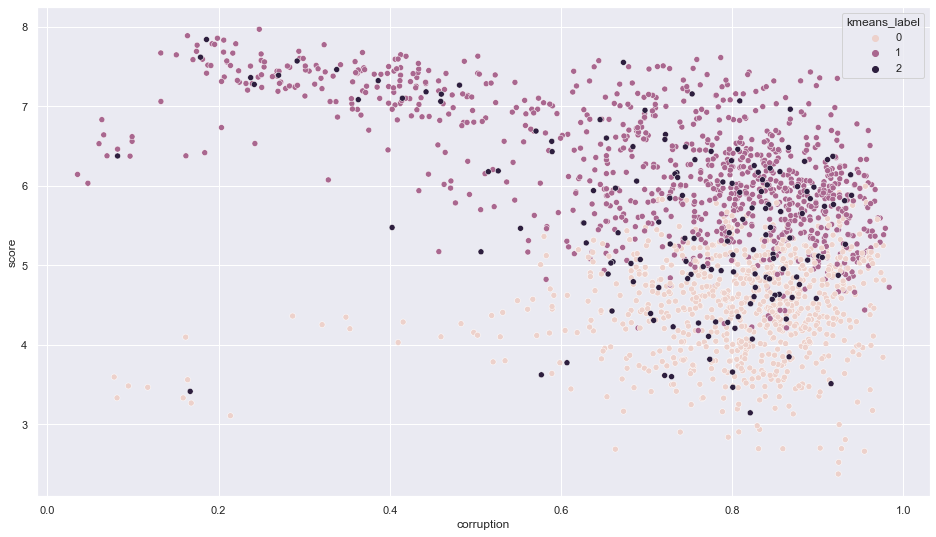

In [30]:
sns.scatterplot(data=to_cluster_vz, x='corruption', y='score', hue='kmeans_label');

Existe uma certa associação entre os dados de corrupção e os dados de score, mas ele não explica muito o score, especialmente porque a maior parte dos registros está entre 0.6 e 1, ou seja, em média no mundo as pessoas percebem corrupção constantemente, mas em países com baixa corrupção o score de felicidade também tende a ser baixo.
Os clusters do KMeans parecem estar organizados primariamente sob o score com um terceiro cluster que considera outras variáveis em sua definição.

**O que aconteceria com um modelo de clusterização sem o score?**

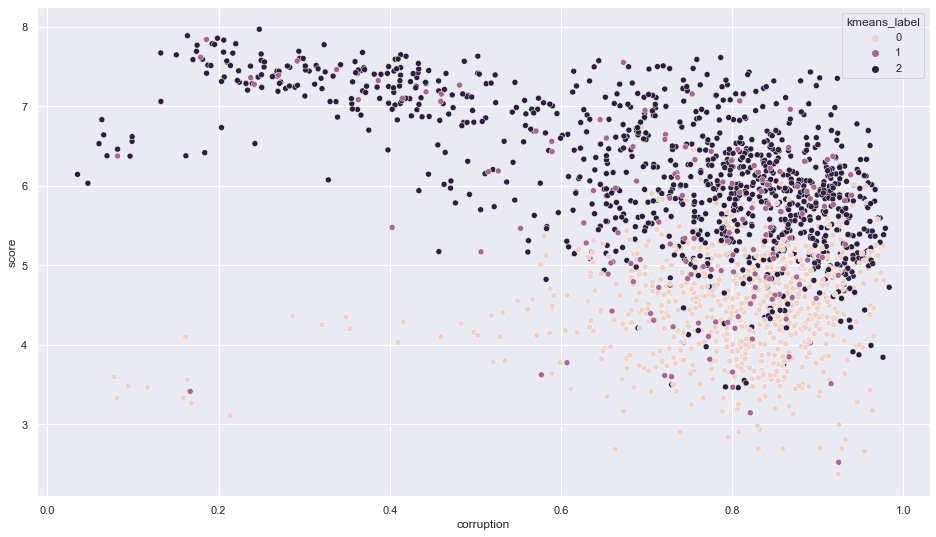

In [31]:
best_kmeans_model = KMeans(n_clusters=3, n_init=20, random_state=42)
best_kmeans_labels_2 = best_kmeans_model.fit_predict(std_to_cluster.drop(columns=['score']))

columns_to_cluster_vz_2 = ['score', 'gdp', 'social_support', 'hle', 'freedom', 'generosity', 'positive_affect', 'negative_affect', 'corruption']
to_cluster_vz_2 = dataset.dropna()[columns_to_cluster_vz_2]
to_cluster_vz_2['kmeans_label'] = best_kmeans_labels_2
to_cluster_vz_2.sample(10)

sns.scatterplot(data=to_cluster_vz_2, x='corruption', y='score', hue='kmeans_label');

O problema é que todos os clusters são muito dispersos em relação aos dados de corrupção, então uma média ou mediana não são uma boa opção.

##### Análise gráfica MeanShift

Mesma coisa do KMeans mas com o MeanShift

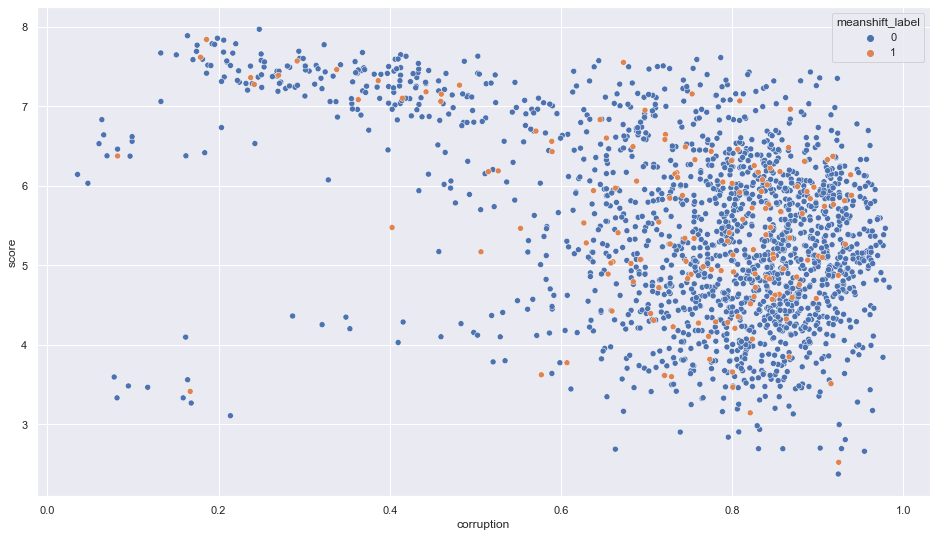

In [32]:
best_meanshift_model = MeanShift()
best_meanshift_labels = best_meanshift_model.fit_predict(std_to_cluster)

columns_to_cluster_vz = ['score', 'gdp', 'social_support', 'hle', 'freedom', 'generosity', 'positive_affect', 'negative_affect', 'corruption']
to_cluster_vz = dataset.dropna()[columns_to_cluster_vz]
to_cluster_vz['meanshift_label'] = best_meanshift_labels
sns.scatterplot(data=to_cluster_vz, x='corruption', y='score', hue='meanshift_label');

Terrível.

##### Análise gráfica SpectralClustering

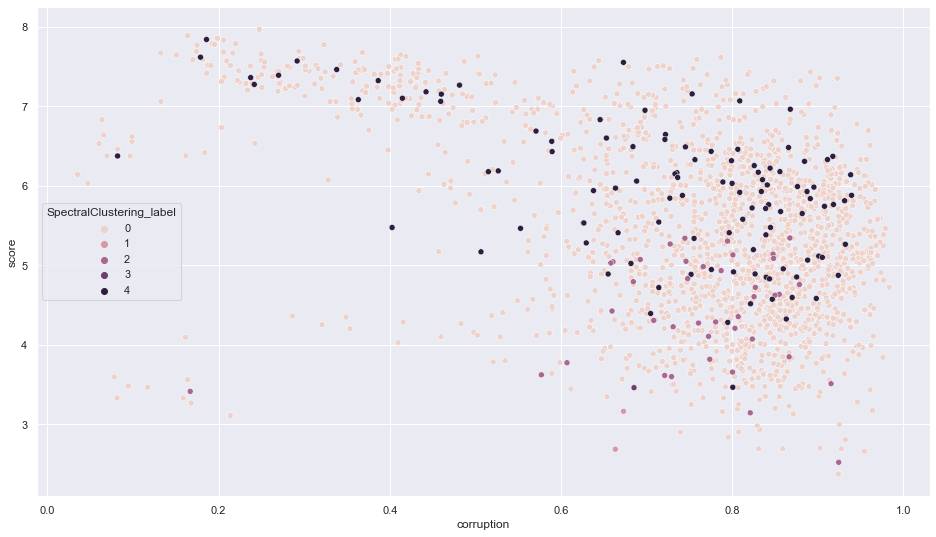

In [33]:
best_sc_model = SpectralClustering(n_clusters=5, n_init=20, random_state=42)
labels = best_sc_model.fit_predict(std_to_cluster)

columns_to_cluster_vz = ['score', 'gdp', 'social_support', 'hle', 'freedom', 'generosity', 'positive_affect', 'negative_affect', 'corruption']
to_cluster_vz = dataset.dropna()[columns_to_cluster_vz]
to_cluster_vz['SpectralClustering_label'] = labels
sns.scatterplot(data=to_cluster_vz, x='corruption', y='score', hue='SpectralClustering_label');

Terrível também para o propósito a ser alcançado.

##### Correlações

Quais correlações existem entre os dados de corrupção e as outras métricas?

<AxesSubplot:>

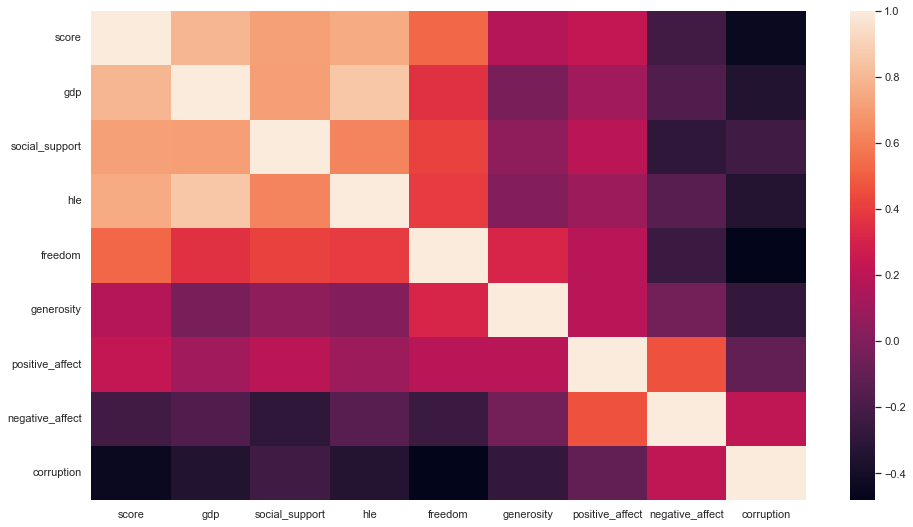

In [34]:
#sns.heatmap();
sns.heatmap(dataset.dropna()[columns_to_cluster_vz].corr())

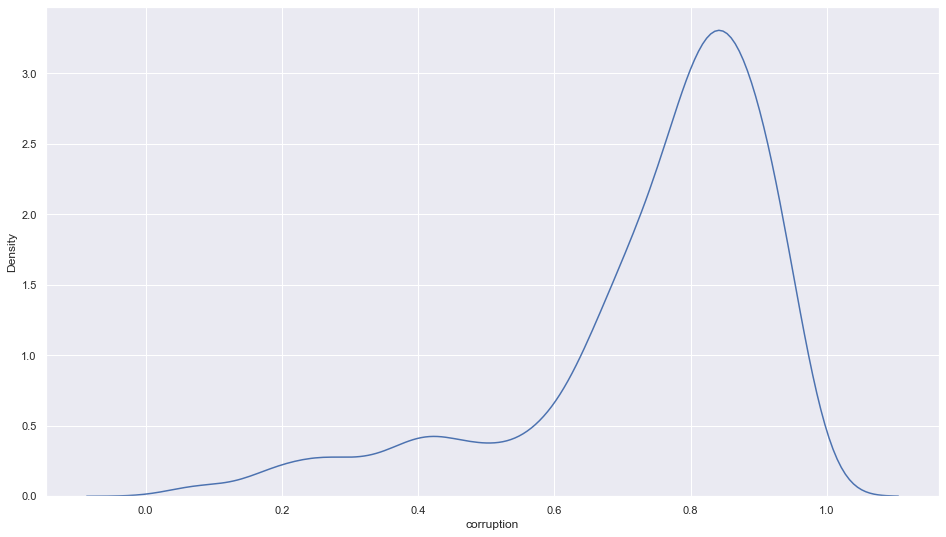

In [35]:
sns.kdeplot(data=dataset, x="corruption");

In [36]:
print(f'Média corrupção mundial: {dataset["corruption"].mean()}')
print(f'Médiana corrupção mundial: {dataset["corruption"].median()}')

Média corrupção mundial: 0.7449791152675701
Médiana corrupção mundial: 0.79959836602211


O mundo é corrupto. A mediana é uma opção razoável de se utilizar neste caso.

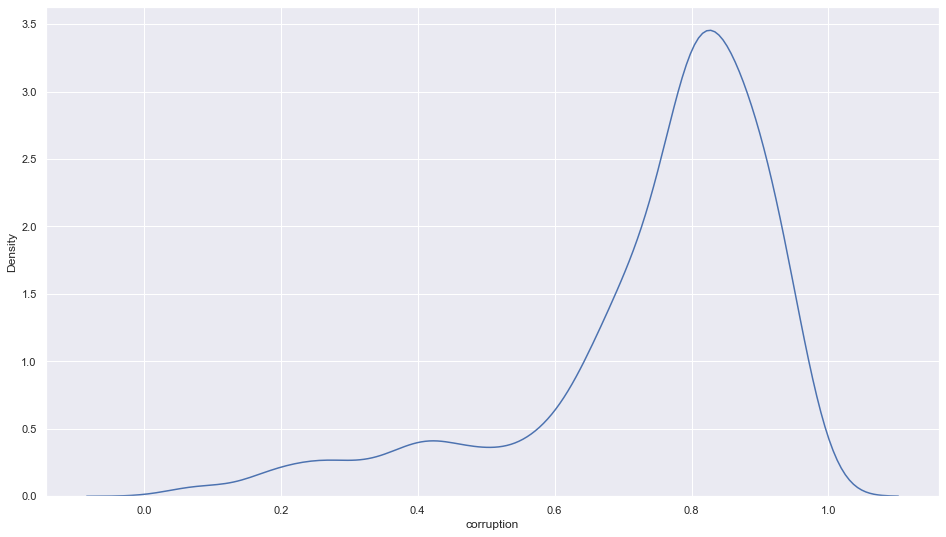

In [37]:
dataset['corruption'].fillna(dataset['corruption'].median(), inplace=True)
sns.kdeplot(data=dataset, x="corruption");

In [38]:
print(f'Média corrupção mundial: {dataset["corruption"].mean()}')
print(f'Médiana corrupção mundial: {dataset["corruption"].median()}')

Média corrupção mundial: 0.7470097642470048
Médiana corrupção mundial: 0.79959836602211


In [39]:
dataset.isna().sum()

country             0
region              0
score               0
gdp                36
social_support     13
hle                55
freedom            32
generosity         89
corruption          0
positive_affect    22
negative_affect    16
year                0
dtype: int64

### Generosity

A análise aqui é semelhante à de `corruption`, mas começarei pelos dados estatísticos.

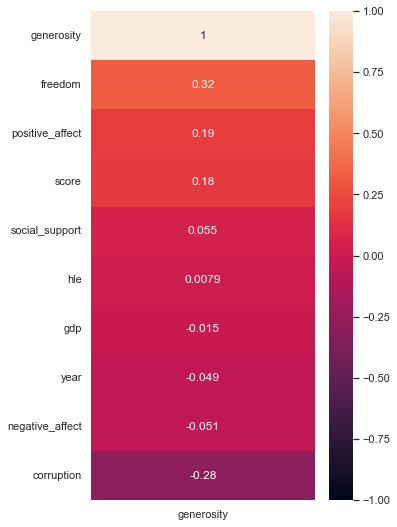

In [53]:
sns.set(rc={"figure.figsize":(5, 9)})
sns.heatmap(dataset.corr()[['generosity']].sort_values(by=['generosity'], ascending=False), annot=True, vmin=-1, vmax=1);


Existe uma certa correlação inversa entre corrupção e generosidade, ainda que baixa, e uma certa correlação entre liberdade e generosidade. Além desses dá para considerar positive_affect e score. Os outros são pouco relevantes para correlação.

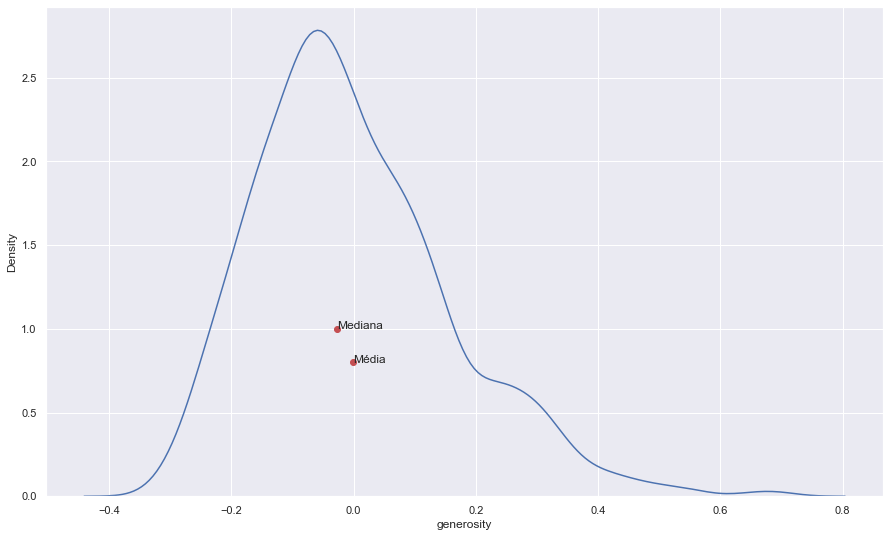

In [76]:
sns.set(rc={"figure.figsize":(15, 9)})
sns.kdeplot(data=dataset, x="generosity")
path_collection = plt.scatter(x=dataset["generosity"].mean(), y=0.8, color='r')
ax = path_collection.figure.axes[0]
ax.annotate('Média', (dataset["generosity"].mean(), 0.8))

path_collection = plt.scatter(x=dataset["generosity"].median(), y=1, color='r')
ax = path_collection.figure.axes[0]
ax.annotate('Mediana', (dataset["generosity"].median(), 1));

print(f'Média generosidade mundial: {dataset["generosity"].mean()}')
print(f'Médiana generosidade mundial: {dataset["generosity"].median()}')

In [60]:
print(f'Média generosidade mundial: {dataset["generosity"].mean()}')
print(f'Médiana generosidade mundial: {dataset["generosity"].median()}')

Média generosidade mundial: -0.001023448298993322
Médiana generosidade mundial: -0.0266375206410884


In [81]:
missing_generosity_data_countries = dataset[dataset['generosity'].isna()]['country'].unique()
missing_generosity_data_countries_total = dataset[dataset['country'].isin(missing_generosity_data_countries)]['country'].value_counts()
missing_generosity_data_countries_total

israel                       16
germany                      16
spain                        16
sweden                       16
mexico                       16
turkey                       16
jordan                       16
japan                        16
italy                        16
south korea                  16
india                        16
united kingdom               16
saudi arabia                 16
egypt                        16
denmark                      16
united states                16
venezuela                    16
china                        16
france                       16
brazil                       16
greece                       15
nepal                        15
vietnam                      15
belgium                      15
poland                       15
palestinian territories      15
pakistan                     15
netherlands                  15
lebanon                      15
australia                    15
kosovo                       15
hungary 

In [87]:
dataset.query("country == 'iran'").sort_values(by=['year'], ascending=True)

,country,region,score,gdp,social_support,hle,freedom,generosity,corruption,positive_affect,negative_affect,year
761,iran,middle east and north africa,5.308190,9.392513,0.765978,62.000000,0.651168,NaN,0.636490,0.608226,0.456109,2005
762,iran,middle east and north africa,5.336371,9.497391,0.717592,62.759998,0.532620,0.055538,0.871644,0.625507,0.361320,2007
763,iran,middle east and north africa,5.128988,9.488964,0.632629,63.139999,0.601222,0.052281,0.868343,0.624161,0.345182,2008
764,iran,middle east and north africa,4.767507,9.547193,0.582237,64.139999,0.797574,0.200392,0.664582,0.578114,0.359068,2011
765,iran,middle east and north africa,4.608928,9.457778,0.599543,64.379997,0.764418,NaN,0.677707,0.608598,0.524969,2012
766,iran,middle east and north africa,5.139579,9.443441,0.663707,64.620003,0.730215,0.215557,0.685038,0.659088,0.551840,2013
767,iran,middle east and north africa,4.682224,9.475666,0.644064,64.860001,0.766823,0.240678,0.639682,0.618345,0.511569,2014
768,iran,middle east and north africa,4.749956,9.449208,0.572407,65.099998,0.780383,0.176360,0.698951,0.644849,0.519858,2015
769,iran,middle east and north africa,4.652731,9.561364,0.566281,65.400002,0.773304,0.185618,0.712783,0.686765,0.525877,2016
770,iran,middle east and north africa,4.716783,9.584374,0.714233,65.699997,0.730635,0.218477,0.714941,0.693666,0.438534,2017


In [82]:
missing_generosity_data_countries = dataset[dataset['generosity'].isna()]['country'].unique()
missing_generosity_data_countries_total = dataset[dataset['country'].isin(missing_generosity_data_countries)]['country'].value_counts()
generosity_by_country = pd.DataFrame([dataset[dataset['generosity'].isna()]['country'].value_counts(), missing_generosity_data_countries_total]).T
generosity_by_country.columns = ['total_missing_generosity_data', 'total_data']
generosity_by_country['tx'] = (generosity_by_country['total_missing_generosity_data'] / generosity_by_country['total_data'])
generosity_by_country.sort_values(by='tx', ascending=False, inplace=True)
generosity_by_country


,total_missing_generosity_data,total_data,tx
cuba,1,1,1.000000
south sudan,4,4,1.000000
somaliland region,4,4,1.000000
somalia,3,3,1.000000
north cyprus,7,8,0.875000
iran,5,14,0.357143
kuwait,4,12,0.333333
venezuela,4,16,0.250000
bahrain,3,12,0.250000
algeria,2,9,0.222222


#### $TX < 0.5$

In [88]:
tx_05_countries = generosity_by_country.query("tx < 0.5").reset_index().rename(columns={'index': 'country'})['country'].tolist()
tx_05_countries

['iran',
 'kuwait',
 'venezuela',
 'bahrain',
 'algeria',
 'united arab emirates',
 'taiwan province of china',
 'qatar',
 'palestinian territories',
 'yemen',
 'japan',
 'germany',
 'brazil',
 'iceland',
 'hong kong s.a.r. of china',
 'malta',
 'rwanda',
 'czech republic',
 'cyprus',
 'romania',
 'greece',
 'pakistan',
 'netherlands',
 'belgium',
 'vietnam',
 'nepal',
 'poland',
 'hungary',
 'australia',
 'lebanon',
 'kosovo',
 'jordan',
 'egypt',
 'mexico',
 'france',
 'sweden',
 'italy',
 'israel',
 'saudi arabia',
 'india',
 'south korea',
 'denmark',
 'china',
 'united states',
 'united kingdom',
 'turkey',
 'spain']

In [89]:
df_tx_05_countries = dataset[dataset['country'].isin(tx_05_countries) & dataset['generosity'].isna()][['country', 'year']]
for country in df_tx_05_countries.itertuples():
    before = dataset[(dataset['country'] == country.country) & (dataset['year'] < country.year)][['generosity', 'year']].sort_values(by='year', ascending=False)['generosity'].values
    after = dataset[(dataset['country'] == country.country) & (dataset['year'] > country.year)][['generosity', 'year']].sort_values(by='year', ascending=False)['generosity'].values
    
    total = []
    if(len(before) > 0):
        total.append(before[0])
    if(len(after) > 0):
        total.append(after[0])    

    dataset.loc[country.Index, 'generosity'] = np.mean(total)
dataset[dataset['generosity'].isna()]['country'].value_counts()

In [90]:
dataset[dataset['generosity'].isna()]['country'].value_counts()

north cyprus         7
somaliland region    4
south sudan          4
somalia              3
cuba                 1
Name: country, dtype: int64

#### $TX >= 0.5$

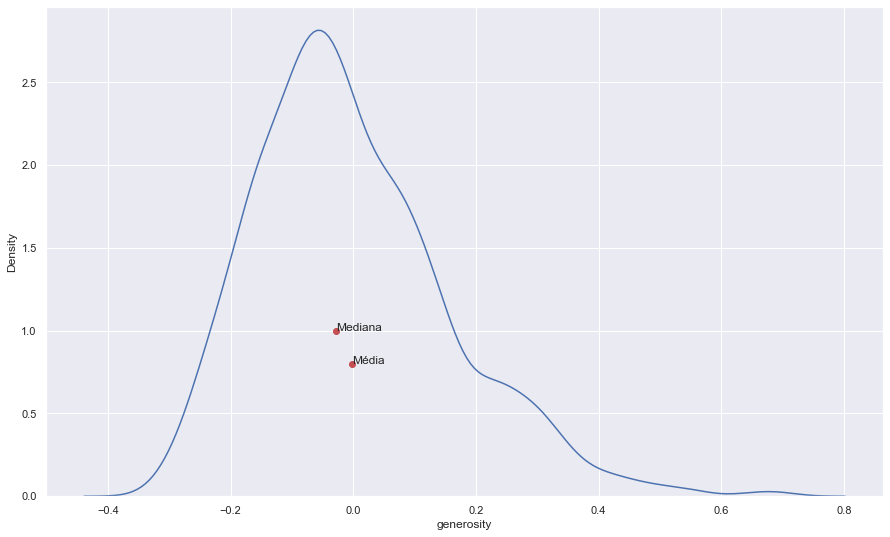

In [91]:
dataset['generosity'].fillna(dataset['generosity'].median(), inplace=True)

sns.set(rc={"figure.figsize":(15, 9)})
sns.kdeplot(data=dataset, x="generosity")
path_collection = plt.scatter(x=dataset["generosity"].mean(), y=0.8, color='r')
ax = path_collection.figure.axes[0]
ax.annotate('Média', (dataset["generosity"].mean(), 0.8))

path_collection = plt.scatter(x=dataset["generosity"].median(), y=1, color='r')
ax = path_collection.figure.axes[0]
ax.annotate('Mediana', (dataset["generosity"].median(), 1));

In [92]:
print(f'Média generosidade mundial: {dataset["generosity"].mean()}')
print(f'Médiana generosidade mundial: {dataset["generosity"].median()}')

Média generosidade mundial: -0.00215502347709774
Médiana generosidade mundial: -0.027709512040019


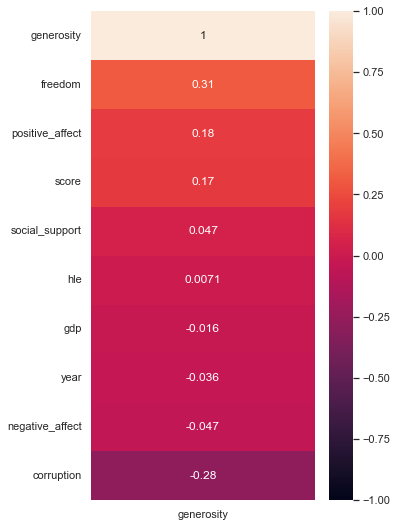

In [93]:
sns.set(rc={"figure.figsize":(5, 9)})
sns.heatmap(dataset.corr()[['generosity']].sort_values(by=['generosity'], ascending=False), annot=True, vmin=-1, vmax=1);

In [94]:
dataset.isna().sum()

country             0
region              0
score               0
gdp                36
social_support     13
hle                55
freedom            32
generosity          0
corruption          0
positive_affect    22
negative_affect    16
year                0
dtype: int64

### HLE

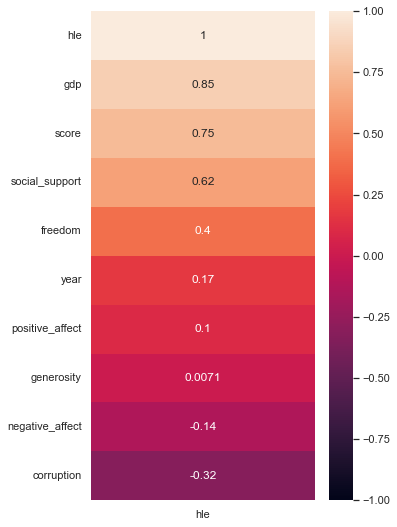

In [95]:
sns.set(rc={"figure.figsize":(5, 9)})
sns.heatmap(dataset.corr()[['hle']].sort_values(by=['hle'], ascending=False), annot=True, vmin=-1, vmax=1);


Aqui as correlações são bem maiores, especialmente com freedom, social_support, score e gdp.

Média hle mundial: 63.47850266100435
Médiana hle mundial: 65.27999877929688


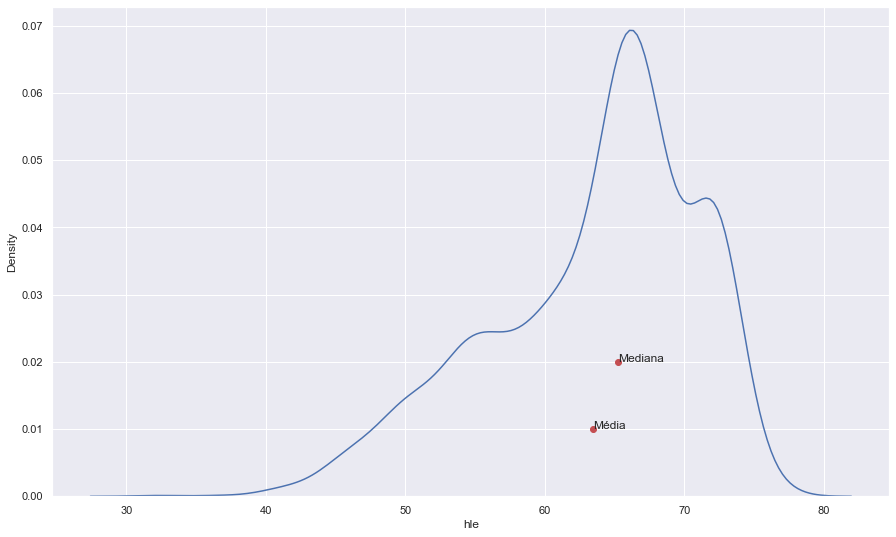

In [100]:
sns.set(rc={"figure.figsize":(15, 9)})
sns.kdeplot(data=dataset, x="hle")
path_collection = plt.scatter(x=dataset["hle"].mean(), y=0.01, color='r')
ax = path_collection.figure.axes[0]
ax.annotate('Média', (dataset["hle"].mean(), 0.01))

path_collection = plt.scatter(x=dataset["hle"].median(), y=0.02, color='r')
ax = path_collection.figure.axes[0]
ax.annotate('Mediana', (dataset["hle"].median(), 0.02));

print(f'Média hle mundial: {dataset["hle"].mean()}')
print(f'Médiana hle mundial: {dataset["hle"].median()}')

In [108]:
missing_hle_data_countries = dataset[dataset['hle'].isna()]['country'].unique()
missing_hle_data_countries_total = dataset[dataset['country'].isin(missing_hle_data_countries)]['country'].value_counts()
missing_hle_data_countries_mean = dataset[dataset['country'].isin(missing_hle_data_countries)].groupby(by='country').mean()['hle']
hle_by_country = pd.DataFrame([dataset[dataset['hle'].isna()]['country'].value_counts(), missing_hle_data_countries_total, missing_hle_data_countries_mean]).T
hle_by_country.columns = ['total_missing_hle_data', 'total_data', 'hle_mean']
hle_by_country['tx'] = (hle_by_country['total_missing_hle_data'] / hle_by_country['total_data'])
hle_by_country.sort_values(by='tx', ascending=False, inplace=True)
hle_by_country


,total_missing_hle_data,total_data,hle_mean,tx
somaliland region,4.0,4.0,NaN,1.000000
kosovo,14.0,15.0,63.812744,0.933333
hong kong s.a.r. of china,11.0,12.0,76.820091,0.916667
north cyprus,7.0,8.0,73.897537,0.875000
taiwan province of china,10.0,14.0,69.254999,0.714286
palestinian territories,9.0,15.0,62.054166,0.600000


In [107]:
dataset[dataset['country'].isin(missing_hle_data_countries)].groupby(by='country').mean()['hle']

country
hong kong s.a.r. of china    76.820091
kosovo                       63.812744
north cyprus                 73.897537
palestinian territories      62.054166
somaliland region                  NaN
taiwan province of china     69.254999
Name: hle, dtype: float64

Média hle mundial: 63.52572968031135
Médiana hle mundial: 65.27999877929688


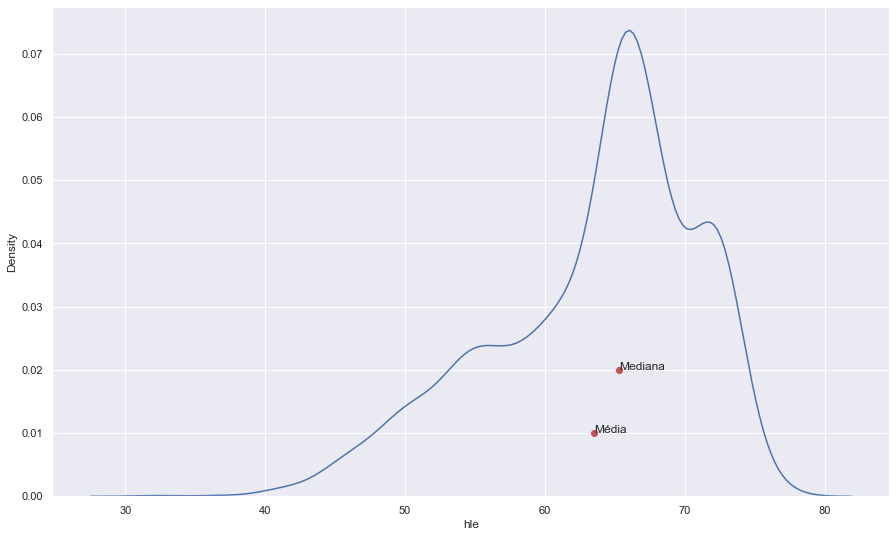

In [109]:
dataset['hle'].fillna(dataset['hle'].median(), inplace=True)

sns.set(rc={"figure.figsize":(15, 9)})
sns.kdeplot(data=dataset, x="hle")
path_collection = plt.scatter(x=dataset["hle"].mean(), y=0.01, color='r')
ax = path_collection.figure.axes[0]
ax.annotate('Média', (dataset["hle"].mean(), 0.01))

path_collection = plt.scatter(x=dataset["hle"].median(), y=0.02, color='r')
ax = path_collection.figure.axes[0]
ax.annotate('Mediana', (dataset["hle"].median(), 0.02));

print(f'Média hle mundial: {dataset["hle"].mean()}')
print(f'Médiana hle mundial: {dataset["hle"].median()}')

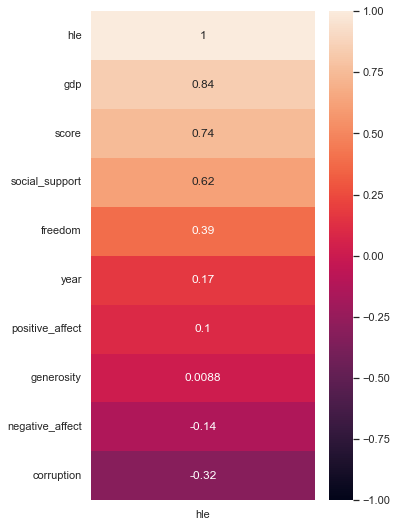

In [110]:
sns.set(rc={"figure.figsize":(5, 9)})
sns.heatmap(dataset.corr()[['hle']].sort_values(by=['hle'], ascending=False), annot=True, vmin=-1, vmax=1);


In [111]:
dataset.isna().sum()

country             0
region              0
score               0
gdp                36
social_support     13
hle                 0
freedom            32
generosity          0
corruption          0
positive_affect    22
negative_affect    16
year                0
dtype: int64

### GDP

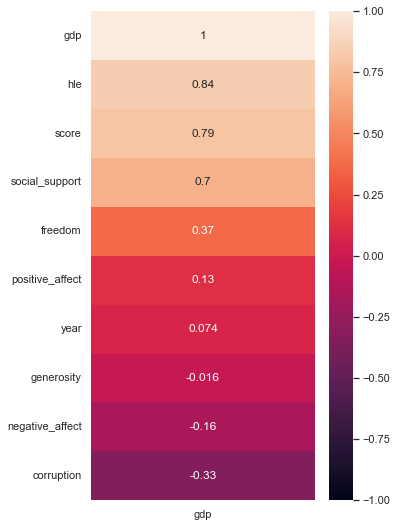

In [112]:
sns.set(rc={"figure.figsize":(5, 9)})
sns.heatmap(dataset.corr()[['gdp']].sort_values(by=['gdp'], ascending=False), annot=True, vmin=-1, vmax=1);


Média gdp mundial: 9.373065241555585
Médiana gdp mundial: 9.462172508239746


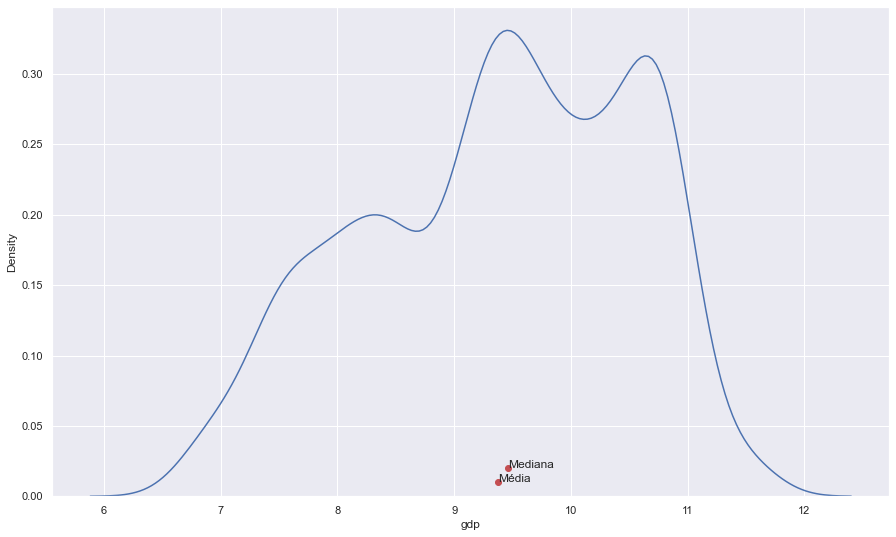

In [115]:
sns.set(rc={"figure.figsize":(15, 9)})
sns.kdeplot(data=dataset, x="gdp")
path_collection = plt.scatter(x=dataset["gdp"].mean(), y=0.01, color='r')
ax = path_collection.figure.axes[0]
ax.annotate('Média', (dataset["gdp"].mean(), 0.01))

path_collection = plt.scatter(x=dataset["gdp"].median(), y=0.02, color='r')
ax = path_collection.figure.axes[0]
ax.annotate('Mediana', (dataset["gdp"].median(), 0.02));

print(f'Média gdp mundial: {dataset["gdp"].mean()}')
print(f'Médiana gdp mundial: {dataset["gdp"].median()}')

Esses dados já são muito menos densos que os anteriores.

In [116]:
missing_gdp_data_countries = dataset[dataset['gdp'].isna()]['country'].unique()
missing_gdp_data_countries_total = dataset[dataset['country'].isin(missing_gdp_data_countries)]['country'].value_counts()
missing_gdp_data_countries_mean = dataset[dataset['country'].isin(missing_gdp_data_countries)].groupby(by='country').mean()['gdp']
gdp_by_country = pd.DataFrame([dataset[dataset['gdp'].isna()]['country'].value_counts(), missing_gdp_data_countries_total, missing_gdp_data_countries_mean]).T
gdp_by_country.columns = ['total_missing_gdp_data', 'total_data', 'gdp_mean']
gdp_by_country['tx'] = (gdp_by_country['total_missing_gdp_data'] / gdp_by_country['total_data'])
gdp_by_country.sort_values(by='tx', ascending=False, inplace=True)
gdp_by_country


,total_missing_gdp_data,total_data,gdp_mean,tx
somaliland region,4.0,4.0,NaN,1.000000
south sudan,4.0,4.0,NaN,1.000000
somalia,3.0,3.0,NaN,1.000000
cuba,1.0,1.0,NaN,1.000000
north cyprus,7.0,8.0,10.576036,0.875000
iran,3.0,14.0,9.498388,0.214286
taiwan province of china,3.0,14.0,10.756200,0.214286
venezuela,3.0,16.0,9.448779,0.187500
yemen,2.0,13.0,8.055039,0.153846
palestinian territories,2.0,15.0,8.409006,0.133333


#### $Tx < 0.5$

In [117]:
df_tx_05_countries = dataset[dataset['country'].isin(tx_05_countries) & dataset['gdp'].isna()][['country', 'year']]
for country in df_tx_05_countries.itertuples():
    before = dataset[(dataset['country'] == country.country) & (dataset['year'] < country.year)][['gdp', 'year']].sort_values(by='year', ascending=False)['gdp'].values
    after = dataset[(dataset['country'] == country.country) & (dataset['year'] > country.year)][['gdp', 'year']].sort_values(by='year', ascending=False)['gdp'].values
    
    total = []
    if(len(before) > 0):
        total.append(before[0])
    if(len(after) > 0):
        total.append(after[0])    

    dataset.loc[country.Index, 'gdp'] = np.mean(total)
dataset[dataset['gdp'].isna()]['country'].value_counts()

north cyprus         7
somaliland region    4
south sudan          4
somalia              3
cuba                 1
Name: country, dtype: int64

#### $Tx >= 0.5$

Média gdp mundial: 9.374486026883185
Médiana gdp mundial: 9.45789098739624


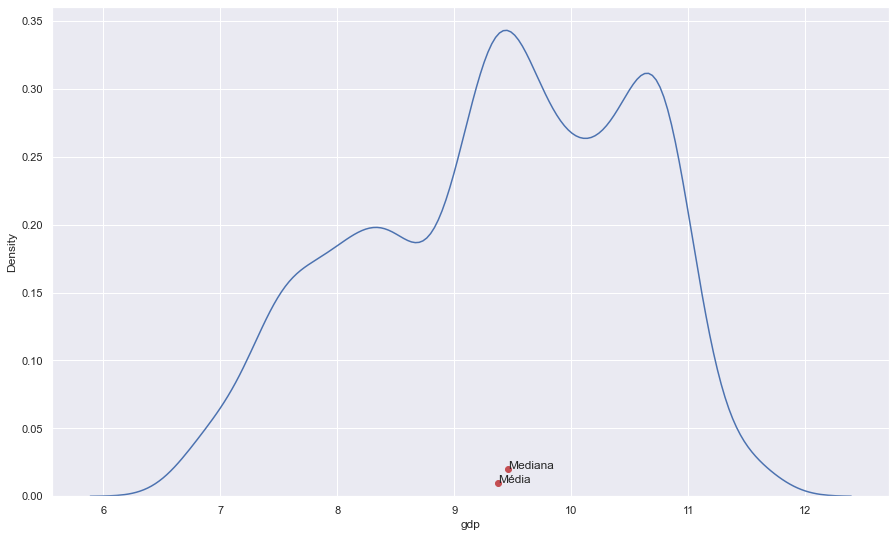

In [118]:
dataset['gdp'].fillna(dataset['gdp'].mean(), inplace=True)

sns.set(rc={"figure.figsize":(15, 9)})
sns.kdeplot(data=dataset, x="gdp")
path_collection = plt.scatter(x=dataset["gdp"].mean(), y=0.01, color='r')
ax = path_collection.figure.axes[0]
ax.annotate('Média', (dataset["gdp"].mean(), 0.01))

path_collection = plt.scatter(x=dataset["gdp"].median(), y=0.02, color='r')
ax = path_collection.figure.axes[0]
ax.annotate('Mediana', (dataset["gdp"].median(), 0.02));

print(f'Média gdp mundial: {dataset["gdp"].mean()}')
print(f'Médiana gdp mundial: {dataset["gdp"].median()}')

In [119]:
dataset.isna().sum()

country             0
region              0
score               0
gdp                 0
social_support     13
hle                 0
freedom            32
generosity          0
corruption          0
positive_affect    22
negative_affect    16
year                0
dtype: int64

### Freedom

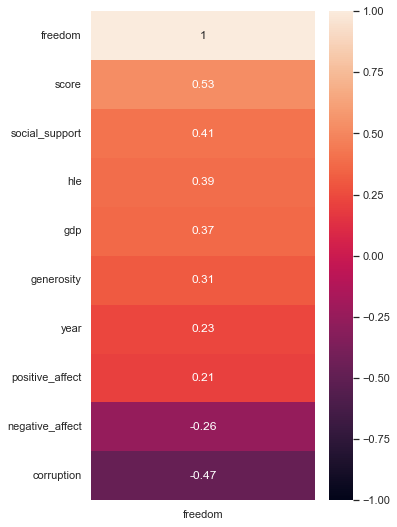

In [120]:
sns.set(rc={"figure.figsize":(5, 9)})
sns.heatmap(dataset.corr()[['freedom']].sort_values(by=['freedom'], ascending=False), annot=True, vmin=-1, vmax=1);

Média freedom mundial: 0.7461013038501157
Médiana freedom mundial: 0.766931414604187


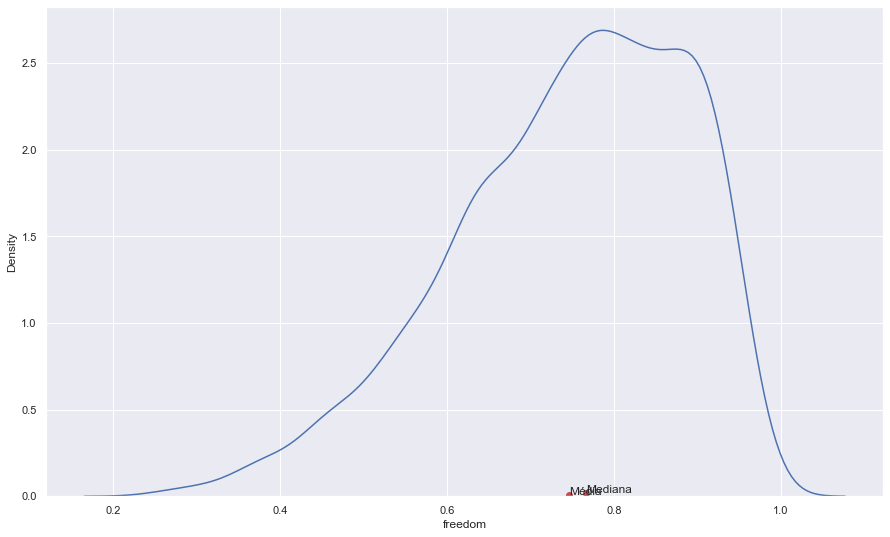

In [121]:
sns.set(rc={"figure.figsize":(15, 9)})
sns.kdeplot(data=dataset, x="freedom")
path_collection = plt.scatter(x=dataset["freedom"].mean(), y=0.01, color='r')
ax = path_collection.figure.axes[0]
ax.annotate('Média', (dataset["freedom"].mean(), 0.01))

path_collection = plt.scatter(x=dataset["freedom"].median(), y=0.02, color='r')
ax = path_collection.figure.axes[0]
ax.annotate('Mediana', (dataset["freedom"].median(), 0.02));

print(f'Média freedom mundial: {dataset["freedom"].mean()}')
print(f'Médiana freedom mundial: {dataset["freedom"].median()}')

In [122]:
missing_freedom_data_countries = dataset[dataset['freedom'].isna()]['country'].unique()
missing_freedom_data_countries_total = dataset[dataset['country'].isin(missing_freedom_data_countries)]['country'].value_counts()
missing_freedom_data_countries_mean = dataset[dataset['country'].isin(missing_freedom_data_countries)].groupby(by='country').mean()['freedom']
freedom_by_country = pd.DataFrame([dataset[dataset['freedom'].isna()]['country'].value_counts(), missing_freedom_data_countries_total, missing_freedom_data_countries_mean]).T
freedom_by_country.columns = ['total_missing_freedom_data', 'total_data', 'freedom_mean']
freedom_by_country['tx'] = (freedom_by_country['total_missing_freedom_data'] / freedom_by_country['total_data'])
freedom_by_country.sort_values(by='tx', ascending=False, inplace=True)
freedom_by_country


,total_missing_freedom_data,total_data,freedom_mean,tx
qatar,2.0,5.0,0.898004,0.400000
china,5.0,16.0,0.851083,0.312500
algeria,2.0,9.0,0.513396,0.222222
vietnam,3.0,15.0,0.887302,0.200000
tajikistan,3.0,16.0,0.780692,0.187500
turkmenistan,2.0,11.0,0.787891,0.181818
uzbekistan,2.0,14.0,0.935543,0.142857
jordan,2.0,16.0,0.743207,0.125000
myanmar,1.0,10.0,0.838188,0.100000
laos,1.0,10.0,0.898706,0.100000


In [124]:
tx_05_countries = freedom_by_country.query("tx < 0.5").reset_index().rename(columns={'index': 'country'})['country'].tolist()
tx_05_countries

['qatar',
 'china',
 'algeria',
 'vietnam',
 'tajikistan',
 'turkmenistan',
 'uzbekistan',
 'jordan',
 'myanmar',
 'laos',
 'bahrain',
 'madagascar',
 'kuwait',
 'iraq',
 'united arab emirates',
 'kosovo',
 'saudi arabia',
 'egypt',
 'cambodia']

In [125]:
df_tx_05_countries = dataset[dataset['country'].isin(tx_05_countries) & dataset['freedom'].isna()][['country', 'year']]
for country in df_tx_05_countries.itertuples():
    before = dataset[(dataset['country'] == country.country) & (dataset['year'] < country.year)][['freedom', 'year']].sort_values(by='year', ascending=False)['freedom'].values
    after = dataset[(dataset['country'] == country.country) & (dataset['year'] > country.year)][['freedom', 'year']].sort_values(by='year', ascending=False)['freedom'].values
    
    total = []
    if(len(before) > 0):
        total.append(before[0])
    if(len(after) > 0):
        total.append(after[0])    

    dataset.loc[country.Index, 'freedom'] = np.mean(total)
dataset[dataset['freedom'].isna()]['country'].value_counts()

Series([], Name: country, dtype: int64)

In [126]:
dataset.isna().sum()

country             0
region              0
score               0
gdp                 0
social_support     13
hle                 0
freedom             0
generosity          0
corruption          0
positive_affect    22
negative_affect    16
year                0
dtype: int64

### positive_affect

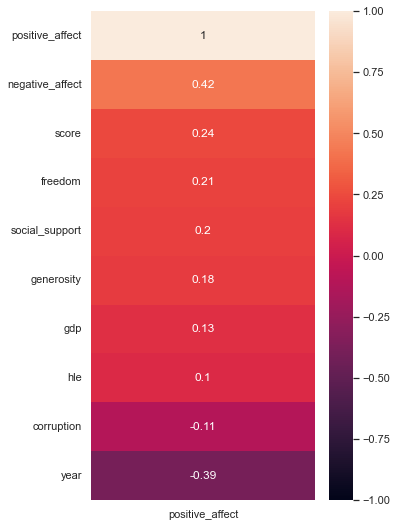

In [127]:
sns.set(rc={"figure.figsize":(5, 9)})
sns.heatmap(dataset.corr()[['positive_affect']].sort_values(by=['positive_affect'], ascending=False), annot=True, vmin=-1, vmax=1);

Média positive_affect mundial: 0.6590397481829904
Médiana positive_affect mundial: 0.7057691514492035


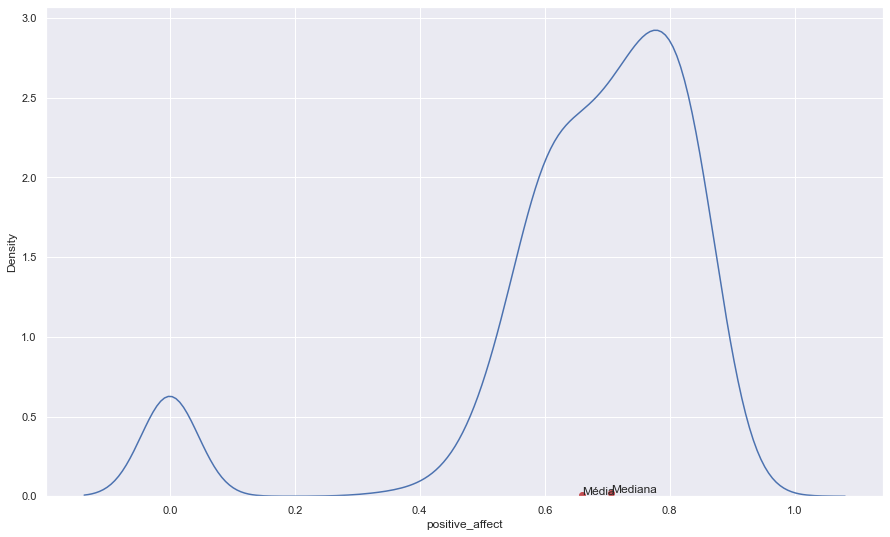

In [128]:
sns.set(rc={"figure.figsize":(15, 9)})
sns.kdeplot(data=dataset, x="positive_affect")
path_collection = plt.scatter(x=dataset["positive_affect"].mean(), y=0.01, color='r')
ax = path_collection.figure.axes[0]
ax.annotate('Média', (dataset["positive_affect"].mean(), 0.01))

path_collection = plt.scatter(x=dataset["positive_affect"].median(), y=0.02, color='r')
ax = path_collection.figure.axes[0]
ax.annotate('Mediana', (dataset["positive_affect"].median(), 0.02));

print(f'Média positive_affect mundial: {dataset["positive_affect"].mean()}')
print(f'Médiana positive_affect mundial: {dataset["positive_affect"].median()}')

In [129]:
missing_positive_affect_data_countries = dataset[dataset['positive_affect'].isna()]['country'].unique()
missing_positive_affect_data_countries_total = dataset[dataset['country'].isin(missing_positive_affect_data_countries)]['country'].value_counts()
missing_positive_affect_data_countries_mean = dataset[dataset['country'].isin(missing_positive_affect_data_countries)].groupby(by='country').mean()['positive_affect']
positive_affect_by_country = pd.DataFrame([dataset[dataset['positive_affect'].isna()]['country'].value_counts(), missing_positive_affect_data_countries_total, missing_positive_affect_data_countries_mean]).T
positive_affect_by_country.columns = ['total_missing_positive_affect_data', 'total_data', 'positive_affect_mean']
positive_affect_by_country['tx'] = (positive_affect_by_country['total_missing_positive_affect_data'] / positive_affect_by_country['total_data'])
positive_affect_by_country.sort_values(by='tx', ascending=False, inplace=True)
positive_affect_by_country


,total_missing_positive_affect_data,total_data,positive_affect_mean,tx
oman,1.0,1.0,NaN,1.000000
maldives,1.0,2.0,0.000000,0.500000
qatar,2.0,5.0,0.734913,0.400000
djibouti,1.0,4.0,0.665339,0.250000
jordan,3.0,16.0,0.601127,0.187500
united arab emirates,2.0,14.0,0.706001,0.142857
algeria,1.0,9.0,0.532326,0.111111
morocco,1.0,11.0,0.595419,0.090909
bahrain,1.0,12.0,0.656087,0.083333
kuwait,1.0,12.0,0.677021,0.083333


### negative_affect

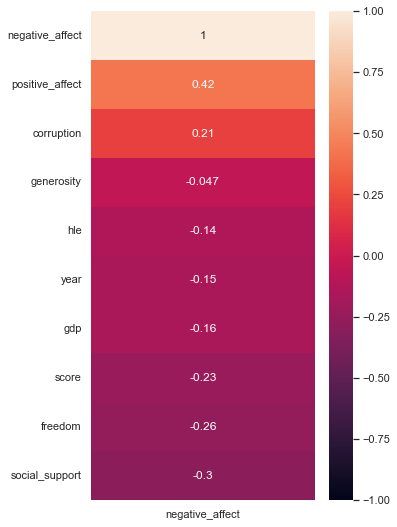

In [130]:
sns.set(rc={"figure.figsize":(5, 9)})
sns.heatmap(dataset.corr()[['negative_affect']].sort_values(by=['negative_affect'], ascending=False), annot=True, vmin=-1, vmax=1);

Média negative_affect mundial: 0.24933268604343836
Médiana negative_affect mundial: 0.2493447214365005


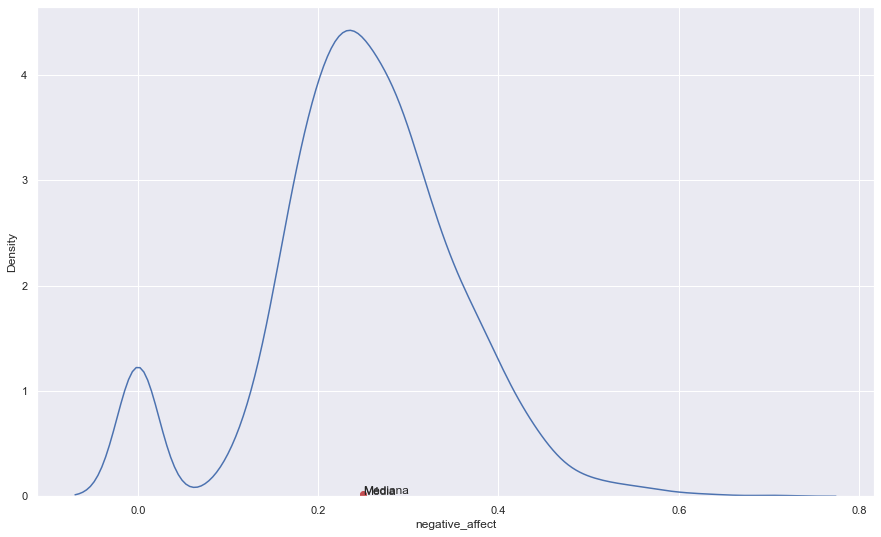

In [131]:
sns.set(rc={"figure.figsize":(15, 9)})
sns.kdeplot(data=dataset, x="negative_affect")
path_collection = plt.scatter(x=dataset["negative_affect"].mean(), y=0.01, color='r')
ax = path_collection.figure.axes[0]
ax.annotate('Média', (dataset["negative_affect"].mean(), 0.01))

path_collection = plt.scatter(x=dataset["negative_affect"].median(), y=0.02, color='r')
ax = path_collection.figure.axes[0]
ax.annotate('Mediana', (dataset["negative_affect"].median(), 0.02));

print(f'Média negative_affect mundial: {dataset["negative_affect"].mean()}')
print(f'Médiana negative_affect mundial: {dataset["negative_affect"].median()}')

In [132]:
missing_negative_affect_data_countries = dataset[dataset['negative_affect'].isna()]['country'].unique()
missing_negative_affect_data_countries_total = dataset[dataset['country'].isin(missing_negative_affect_data_countries)]['country'].value_counts()
missing_negative_affect_data_countries_mean = dataset[dataset['country'].isin(missing_negative_affect_data_countries)].groupby(by='country').mean()['negative_affect']
negative_affect_by_country = pd.DataFrame([dataset[dataset['negative_affect'].isna()]['country'].value_counts(), missing_negative_affect_data_countries_total, missing_negative_affect_data_countries_mean]).T
negative_affect_by_country.columns = ['total_missing_negative_affect_data', 'total_data', 'negative_affect_mean']
negative_affect_by_country['tx'] = (negative_affect_by_country['total_missing_negative_affect_data'] / negative_affect_by_country['total_data'])
negative_affect_by_country.sort_values(by='tx', ascending=False, inplace=True)
negative_affect_by_country


,total_missing_negative_affect_data,total_data,negative_affect_mean,tx
maldives,1.0,2.0,0.000000,0.500000
qatar,2.0,5.0,0.302685,0.400000
djibouti,1.0,4.0,0.177639,0.250000
jordan,3.0,16.0,0.279348,0.187500
algeria,1.0,9.0,0.229430,0.111111
morocco,1.0,11.0,0.258015,0.090909
bahrain,1.0,12.0,0.321404,0.083333
kuwait,1.0,12.0,0.221926,0.083333
tunisia,1.0,13.0,0.308007,0.076923
united arab emirates,1.0,14.0,0.242969,0.071429


### social_support

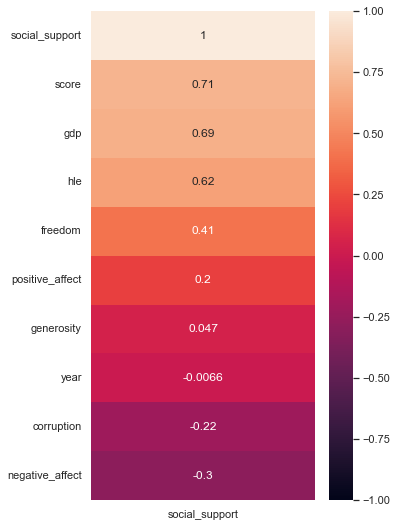

In [133]:
sns.set(rc={"figure.figsize":(5, 9)})
sns.heatmap(dataset.corr()[['social_support']].sort_values(by=['social_support'], ascending=False), annot=True, vmin=-1, vmax=1);

Média social_support mundial: 0.8127087206005764
Médiana social_support mundial: 0.834715723991394


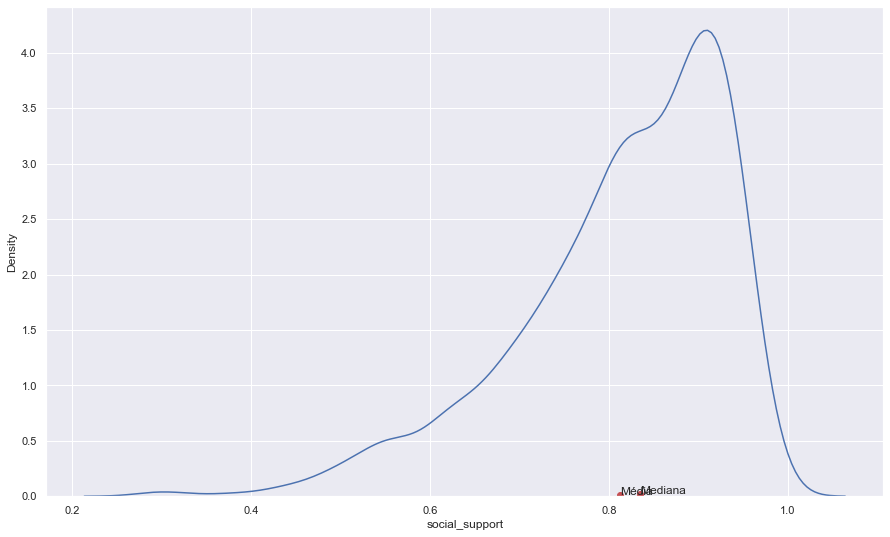

In [134]:
sns.set(rc={"figure.figsize":(15, 9)})
sns.kdeplot(data=dataset, x="social_support")
path_collection = plt.scatter(x=dataset["social_support"].mean(), y=0.01, color='r')
ax = path_collection.figure.axes[0]
ax.annotate('Média', (dataset["social_support"].mean(), 0.01))

path_collection = plt.scatter(x=dataset["social_support"].median(), y=0.02, color='r')
ax = path_collection.figure.axes[0]
ax.annotate('Mediana', (dataset["social_support"].median(), 0.02));

print(f'Média social_support mundial: {dataset["social_support"].mean()}')
print(f'Médiana social_support mundial: {dataset["social_support"].median()}')

In [135]:
missing_social_support_data_countries = dataset[dataset['social_support'].isna()]['country'].unique()
missing_social_support_data_countries_total = dataset[dataset['country'].isin(missing_social_support_data_countries)]['country'].value_counts()
missing_social_support_data_countries_mean = dataset[dataset['country'].isin(missing_social_support_data_countries)].groupby(by='country').mean()['social_support']
social_support_by_country = pd.DataFrame([dataset[dataset['social_support'].isna()]['country'].value_counts(), missing_social_support_data_countries_total, missing_social_support_data_countries_mean]).T
social_support_by_country.columns = ['total_missing_social_support_data', 'total_data', 'social_support_mean']
social_support_by_country['tx'] = (social_support_by_country['total_missing_social_support_data'] / social_support_by_country['total_data'])
social_support_by_country.sort_values(by='tx', ascending=False, inplace=True)
social_support_by_country


,total_missing_social_support_data,total_data,social_support_mean,tx
oman,1.0,1.0,NaN,1.000000
qatar,2.0,5.0,0.863325,0.400000
djibouti,1.0,4.0,0.741326,0.250000
algeria,1.0,9.0,0.803377,0.111111
morocco,1.0,11.0,0.620998,0.090909
bahrain,1.0,12.0,0.878416,0.083333
kuwait,1.0,12.0,0.870627,0.083333
tunisia,1.0,13.0,0.691828,0.076923
united arab emirates,1.0,14.0,0.861076,0.071429
vietnam,1.0,15.0,0.830623,0.066667


A conclusão é que a regra de todos os faltantes pode ser a mesma:

1. Todos os com menos de 50% de dados faltantes são preenchidos com a média dos anos mais próximos.
2. Todos os outros são preenchidos com o menor valor entre mediana  e média mundial.